# Gaussian Process Regression: Airline Passengers Data Set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

   #Passengers
0          112
1          118
2          132
3          129
4          121


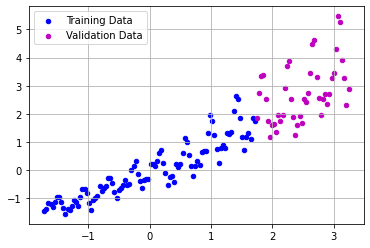

In [2]:
df = pd.read_csv('AirPassengers.csv',usecols=[1])
print(df.head())

X = np.arange(len(df)).reshape(-1,1)
y = df.iloc[:,0].to_numpy().reshape(-1,1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)

scalerX, scalerY = StandardScaler(), StandardScaler()

X_train = scalerX.fit_transform(X_train)
y_train = scalerY.fit_transform(y_train)
X_val = scalerX.transform(X_val)
y_val = scalerY.transform(y_val)

plt.scatter(X_train, y_train, color='b', s=20, label='Training Data')
plt.scatter(X_val, y_val, color='m', s=20, label='Validation Data')
plt.grid()
plt.legend()
plt.show()

## Create GPR class

In [3]:
class GPRegression:
    def __init__(self, X_train, y_train, sigma, theta):
        self.X_train = X_train
        self.y_train = y_train
        self.N_train = X_train.shape[0]
        self.sigma = sigma
        self.theta = theta
        self.K = self.kernel_func(X_train.reshape(-1,1),
                                  X_train.reshape(-1,1))
        
    def kernel_func(self, x1, x2):
        #a = np.exp(-2 * np.sum(np.sin(np.pi * np.abs(x1 - x2) / self.theta[1]) ** 2) / self.theta[2] ** 2)
        return self.theta[0] * np.exp(-self.theta[1] * pairwise_distances(x1, x2, metric='sqeuclidean')) * \
            np.exp(-2 * (np.sin(np.pi * pairwise_distances(x1, x2, metric='manhattan')\
            / self.theta[2]) ** 2) / self.theta[3] ** 2)

    def predict(self, x):
        # For k(x), a single sample x should be reshaped for pairwise distances to work 
        kx = self.kernel_func(x.reshape(1,-1), self.X_train.reshape(-1,1))
        kxx = self.kernel_func(x.reshape(1,-1), x.reshape(1,-1))
        C = np.linalg.inv(self.K + self.sigma ** 2 * np.eye(self.N_train))
        mu = kx @ C @ self.y_train                  # Eq. (6.66), PRML
        sd = kxx + self.sigma ** 2 - kx @ C @ kx.T  # Eq. (6.67), PRML
        return mu, np.sqrt(sd)

## Perform GPR forecasting with Hyper-parameter Optimization
Use scipy 'minimize' to search GPR hyper-parameters in the log space

In [4]:
def objective(hp):
    rmse = 0
    y_pred = np.zeros(len(y_val))
    mdl = GPRegression(X_train, y_train, sigma=1, theta=np.exp(hp))
    for i in range(len(X_val)):
        y_pred[i],_ = mdl.predict(X_val[i])
        rmse += (y_pred[i] - y_val[i]) ** 2
    return np.sqrt(rmse / len(y_val))
    
initial_hp = np.zeros(4)
res = minimize(objective, initial_hp, method="Nelder-Mead")
best_hp = np.exp(res.x)
print(res.message)
print("Best hyper-parameters:")
print(best_hp)

Optimization terminated successfully.
Best hyper-parameters:
[2.50084416e+05 5.04675146e-04 8.33531270e-01 3.90832237e-01]


Get the best GPR and plot results

All RMSE = 0.16885143181479412


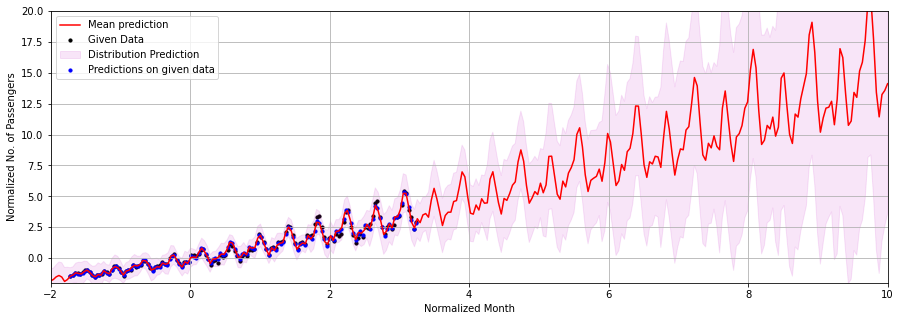

In [5]:
mdl = GPRegression(X_train, y_train, sigma=1, theta=best_hp)
X_fine = np.linspace(-2, 10, 300)
y_pred_fine = np.zeros(X_fine.shape)
sd_pred_fine = np.zeros(X_fine.shape)

X = np.vstack((X_train, X_val))
y = np.vstack((y_train, y_val))

y_pred = np.zeros(y.shape)
for i in range(len(X_fine)):
    y_pred_fine[i], sd_pred_fine[i] = mdl.predict(X_fine[i])

for i in range(len(X)):
    y_pred[i],_ = mdl.predict(X[i])
    
print(f"All RMSE = {np.sqrt(np.mean((y_pred - y) ** 2))}")

plt.figure(figsize=(15,5))
plt.scatter(X, y, s=10, color='k', label='Given Data')
plt.plot(X_fine, y_pred_fine, 'r', label='Mean prediction')

# Draw the filled uncertainty
n_std = 0.5
p1 = n_std * sd_pred_fine + y_pred_fine
p2 = -n_std * sd_pred_fine + y_pred_fine
plt.fill_between(X_fine, p1, p2, color='m', 
                 alpha=0.1, label='Distribution Prediction')
plt.scatter(X, y_pred, s=10, c='b', label='Predictions on given data')
plt.xlabel('Normalized Month')
plt.ylabel('Normalized No. of Passengers')
plt.axis([-2, 10, -2, 20])
plt.legend()
plt.grid()
plt.show()

## Comparison with Built-in GP Regressor

Optimal kernel found:
3.78**2 * RBF(length_scale=6.8) * ExpSineSquared(length_scale=1.24, periodicity=0.417) + WhiteKernel(noise_level=0.0229)
All RMSE = 2.2836133649857815


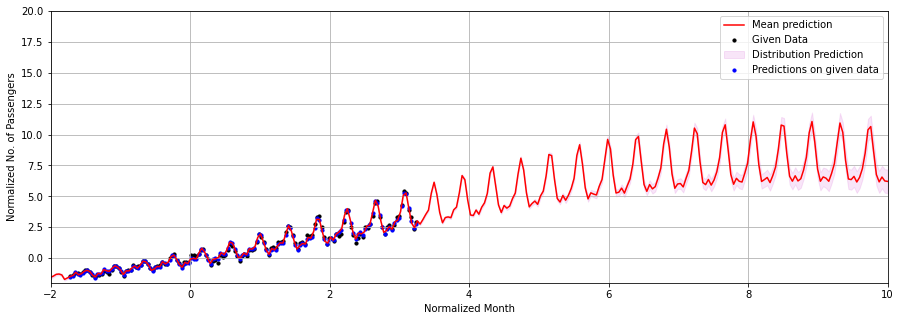

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel

np.random.seed(0)
custom_kernel = 2 * RBF() * ExpSineSquared() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=custom_kernel, 
                               normalize_y=False,
                               n_restarts_optimizer=20)
gpr.fit(X, y)
print('Optimal kernel found:')
print(gpr.kernel_)

y_pred = gpr.predict(X)
y_pred_fine, sd_pred_fine = gpr.predict(X_fine.reshape(-1,1), return_std=True)
print(f"All RMSE = {np.sqrt(np.mean((y_pred - y) ** 2))}")

plt.figure(figsize=(15,5))
plt.scatter(X, y, s=10, color='k', label='Given Data')
plt.plot(X_fine, y_pred_fine, 'r', label='Mean prediction')

# Draw the filled uncertainty
n_std = 0.5
p1 = n_std * sd_pred_fine + y_pred_fine
p2 = -n_std * sd_pred_fine + y_pred_fine
plt.fill_between(X_fine, p1, p2, color='m', 
                 alpha=0.1, label='Distribution Prediction')
plt.scatter(X, y_pred, s=10, c='b', label='Predictions on given data')
plt.xlabel('Normalized Month')
plt.ylabel('Normalized No. of Passengers')
plt.axis([-2, 10, -2, 20])
plt.legend()
plt.grid()
plt.show()